In [15]:
rm(list = ls())
library(tidyverse)
library(haven)      
library(fixest)
library(sandwich) 
library(lmtest)
library(xtable)

dots <- read_dta("dots1960_2005.dta") # Trade flows (every 5 years)
pwt  <- read_dta("pwt.dta")           # GDP and Pop
rta  <- read_dta("RTA.dta")           # Regional Trade Agreements
cu   <- read_dta("CU.dta")            # Currency Unions
dist <- read_dta("dist_cepii.dta")    # Distance & Geo variables

# 1. Prepare PWT (Economic Mass)
# We need to create two copies: one for Origin (o) and one for Destination (d)
pwt_o <- pwt %>%
  select(iso_o = iso3, year, gdp_o = cgdp, pop_o = pop, pc_o = pc)

pwt_d <- pwt %>%
  select(iso_d = iso3, year, gdp_d = cgdp, pop_d = pop, pc_d = pc)

# 2. Merge Data
gravity_df <- dots %>%
  rename(trade = flow_dots) %>%
  # Merge Origin GDP/Pop
  left_join(pwt_o, by = c("iso_o", "year")) %>%
  # Merge Destination GDP/Pop
  left_join(pwt_d, by = c("iso_d", "year")) %>%
  # Merge RTA (Time varying)
  left_join(rta, by = c("iso_o", "iso_d", "year")) %>%
  # Merge Currency Union (Time varying)
  left_join(cu %>% rename(cu = comcur), by = c("iso_o", "iso_d", "year")) %>%
  # Merge Distance/Geo (Time invariant) - Note: dist usually doesn't have year
  left_join(dist, by = c("iso_o", "iso_d"))

# Summary
cat("Number of Observations:", nrow(gravity_df))
cat("\nNumber of Pairs:", n_distinct(paste(gravity_df$iso_o, gravity_df$iso_d)))

num_origin <- length(unique(gravity_df$iso_o))
num_dest <- length(unique(gravity_df$iso_d))
num_total <- length(unique(c(gravity_df$iso_o, gravity_df$iso_d)))

cat("\nNumber of Origin Countries:", num_origin)
cat("\nNumber of Destination Countries:", num_dest)
cat("\nNumber of Total Countries:", num_total)
cat("\nNumber of Years:", length(unique(gravity_df$year)))

vars <- c("trade", "gdp_o", "gdp_d", "pop_o", "pop_d", "pc_o", "pc_d", "dist", "rta", "cu")

# Create summary for counts
summary_counts <- data.frame(
  Variable = c("Number of Origin Countries", "Number of Destination Countries", "Number of Total Countries", "Number of Years"),
  Count = c(num_origin, num_dest, num_total, length(unique(gravity_df$year)))
)

# Create summary for variables
summary_vars <- data.frame(
  Variable = vars,
  Mean = sapply(gravity_df[vars], function(x) if(is.numeric(x)) mean(x, na.rm = TRUE) else NA),
  SD = sapply(gravity_df[vars], function(x) if(is.numeric(x)) sd(x, na.rm = TRUE) else NA),
  Min = sapply(gravity_df[vars], function(x) if(is.numeric(x)) min(x, na.rm = TRUE) else NA),
  Max = sapply(gravity_df[vars], function(x) if(is.numeric(x)) max(x, na.rm = TRUE) else NA)
)

print(summary_counts)
print(summary_vars)

# Save summary stats to LaTeX file with threeparttable
sink("summary_stats.tex")
cat("\\begin{table}[h!]\n")
cat("\\centering\n")
cat("\\caption{Summary Statistics of Gravity Dataset}\n")
cat("\\begin{threeparttable}\n")
cat("\\begin{tabular}{@{} l c @{}}\n")
cat("\\toprule\n")
cat("\\multicolumn{2}{c}{Counts} \\\\\n")
cat("\\midrule\n")
cat("Variable & Count \\\\\n")
cat("\\midrule\n")
for(i in 1:nrow(summary_counts)) {
  cat(summary_counts$Variable[i], " & ", summary_counts$Count[i], " \\\\\n")
}
cat("\\bottomrule\n")
cat("\\end{tabular}\n")
cat("\\vspace{1em}\n")
cat("\\begin{tabular}{@{} l c c c c @{}}\n")
cat("\\toprule\n")
cat("\\multicolumn{5}{c}{Variables} \\\\\n")
cat("\\midrule\n")
cat("Variable & Mean & SD & Min & Max \\\\\n")
cat("\\midrule\n")
for(i in 1:nrow(summary_vars)) {
  cat(summary_vars$Variable[i], " & ", round(summary_vars$Mean[i], 2), " & ", round(summary_vars$SD[i], 2), " & ", round(summary_vars$Min[i], 2), " & ", round(summary_vars$Max[i], 2), " \\\\\n")
}
cat("\\bottomrule\n")
cat("\\end{tabular}\n")
cat("\\begin{tablenotes}\n")
cat("\\small\n")
cat("\\item Note: Counts are for countries and years. Statistics for variables are mean, standard deviation, minimum, and maximum.\n")
cat("\\end{tablenotes}\n")
cat("\\end{threeparttable}\n")
cat("\\end{table}\n")
sink()

  # 3. Cleaning & Transformations
gravity_clean <- gravity_df %>%
  # Replace NAs in binary variables with 0 (Crucial for RTA/CU)
  mutate(
    # Log transformations
    ln_trade = log(trade),
    ln_gdp_o = log(gdp_o),
    ln_gdp_d = log(gdp_d),
    ln_pop_o = log(pop_o),
    ln_pop_d = log(pop_d)
  )

Number of Observations: 361100
Number of Pairs: 36110
Number of Origin Countries: 204
Number of Destination Countries: 204
Number of Total Countries: 204
Number of Years: 10                         Variable Count
1      Number of Origin Countries   204
2 Number of Destination Countries   204
3       Number of Total Countries   204
4                 Number of Years    10
      Variable         Mean           SD       Min          Max
trade    trade 5.020397e+08 2.466072e+10  0.000000 4.673501e+12
gdp_o    gdp_o 5.495388e+03 8.462581e+03 53.399940 7.115808e+04
gdp_d    gdp_d 5.495388e+03 8.462581e+03 53.399940 7.115808e+04
pop_o    pop_o 2.779385e+04 1.044349e+05  9.482000 1.297765e+06
pop_d    pop_d 2.779385e+04 1.044349e+05  9.482000 1.297765e+06
pc_o      pc_o 7.561401e+01 5.826375e+01  8.397971 7.602806e+02
pc_d      pc_d 7.561401e+01 5.826375e+01  8.397971 7.602806e+02
dist      dist 7.813531e+03 4.480708e+03  1.880632 1.995116e+04
rta        rta 2.137339e-02 1.446258e-01  0.000000 

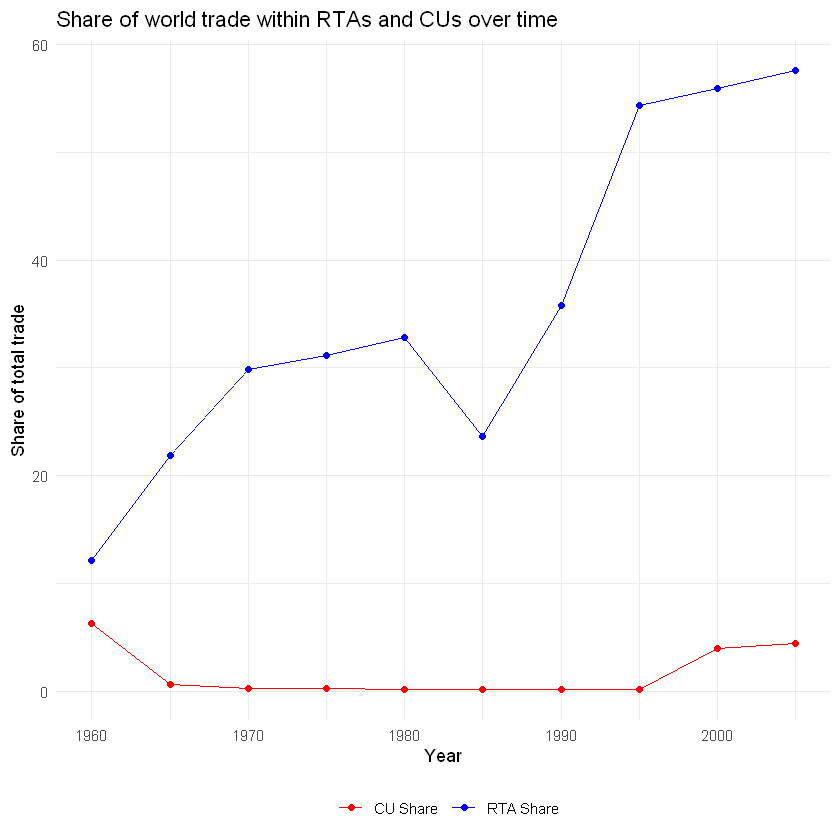

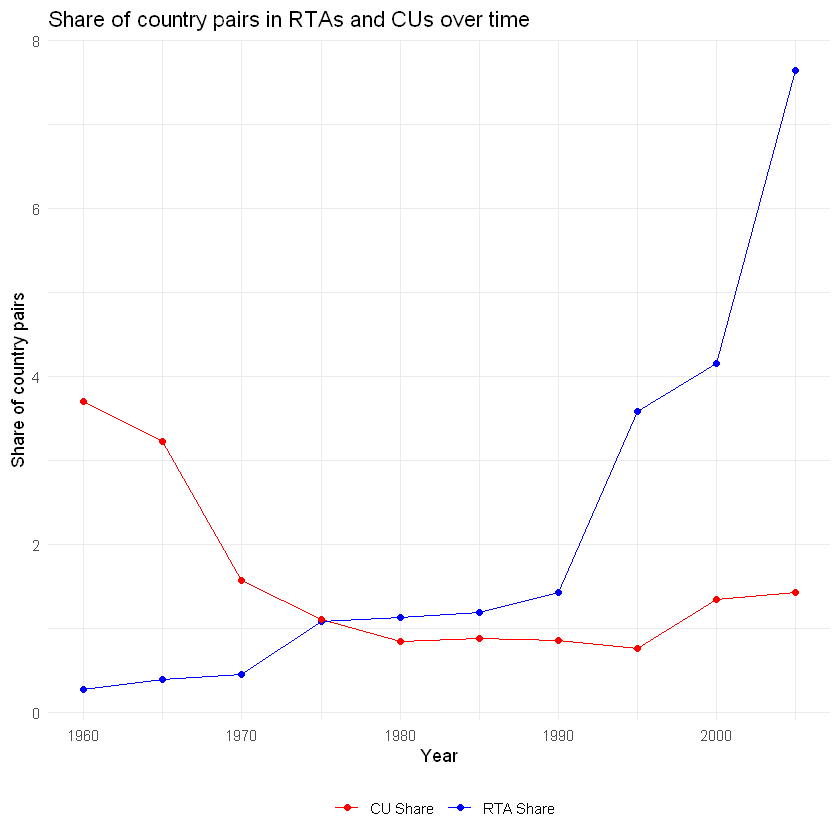

In [ ]:
# ======================
# Question d: Trade and pair shares over time
# ======================

shares_trade <- gravity_clean %>%
  group_by(year) %>%
  summarise(
    share_trade_RTA = sum(trade * rta, na.rm = TRUE) / sum(trade, na.rm = TRUE) * 100,
    share_trade_CU  = sum(trade * cu,  na.rm = TRUE) / sum(trade, na.rm = TRUE) * 100
  )

shares_pairs <- gravity_clean %>%
  group_by(year) %>%
  summarise(
    share_pairs_RTA = mean(rta, na.rm = TRUE) * 100,
    share_pairs_CU  = mean(cu,  na.rm = TRUE) * 100
  )

# Plot trade shares
shares_trade_long <- shares_trade %>%
  select(year, share_trade_RTA, share_trade_CU) %>%
  pivot_longer(
    cols      = -year,
    names_to  = "type",
    values_to = "share"
  ) %>%
  mutate(type = case_match(type, 
                           "share_trade_RTA" ~ "RTA Share", 
                           "share_trade_CU" ~ "CU Share"))

plot_trade <- ggplot(shares_trade_long, aes(x = year, y = share, color = type)) +
  geom_line() +
  geom_point() +
  labs(
    x = "Year",
    y = "Share of total trade",
    color = "", 
    title = "Share of world trade within RTAs and CUs over time"
  ) +
  scale_color_manual(values = c("RTA Share" = "blue", "CU Share" = "red")) +
  theme_minimal() +
  theme(legend.position = "bottom")

print(plot_trade)

# Plot pair shares
shares_pairs_long <- shares_pairs %>%
  select(year, share_pairs_RTA, share_pairs_CU) %>%
  pivot_longer(
    cols      = -year,
    names_to  = "type",
    values_to = "share"
  )%>%
  mutate(type = case_match(type, 
                           "share_pairs_RTA" ~ "RTA Share", 
                           "share_pairs_CU" ~ "CU Share"))

plot_pairs <- ggplot(shares_pairs_long, aes(x = year, y = share, color = type)) +
  geom_line() +
  geom_point() +
  labs(
    x = "Year",
    y = "Share of country pairs",
    color = "",
    title = "Share of country pairs in RTAs and CUs over time"
  ) +
  scale_color_manual(values = c("RTA Share" = "blue", "CU Share" = "red")) +
  theme_minimal() +
  theme(legend.position = "bottom")

print(plot_pairs)

In [4]:
# ======================
# GRAVITY ESTIMATIONS (Question e)
# ======================

# Create pair identifier for clustering
gravity_clean <- gravity_clean %>%
  mutate(
    ln_dist = log(distw),
    pair_id = interaction(iso_o, iso_d, drop = TRUE)
  )

# (e1) Traditional Gravity (GDP + Dist)
mod_e1 <- feols(ln_trade ~ ln_gdp_o + ln_gdp_d + ln_dist + i(year),
               data = gravity_clean, cluster = ~pair_id)

# (e2) Adding CU and RTA
mod_e2 <- feols(ln_trade ~ ln_gdp_o + ln_gdp_d + ln_dist + cu + rta + i(year), 
               data = gravity_clean, cluster = ~pair_id)

# (e3) Adding Historical Ties (Language, Colony)
mod_e3 <- feols(ln_trade ~ ln_gdp_o + ln_gdp_d + ln_dist +
               contig + comlang_off + colony + curcol + smctry + cu + rta + i(year), 
               data = gravity_clean, cluster = ~pair_id)

# (e4) Importer and Exporter Fixed Effects
mod_e4 <- feols(ln_trade ~ ln_gdp_o + ln_gdp_d + ln_dist +
               contig + comlang_off + colony + curcol + smctry + cu + rta +
               i(year) | iso_o + iso_d, 
               data = gravity_clean, cluster = ~pair_id)

etable(mod_e1, mod_e2, mod_e3, mod_e4, headers = c("Naive", "+Policy", "+History", "+CountryFE"))


NOTE: 259,850 observations removed because of NA and infinite values (LHS: 237,150, RHS: 141,921).

NOTE: 260,522 observations removed because of NA and infinite values (LHS: 237,150, RHS: 143,220).

NOTE: 260,522 observations removed because of NA and infinite values (LHS: 237,150, RHS: 143,220).

NOTE: 260,522 observations removed because of NA and infinite values (LHS: 237,150, RHS: 143,220).



,,mod_e1,mod_e2,mod_e3,mod_e4
,<chr>,<chr>,<chr>,<chr>,<chr>
1,,Naive,+Policy,+History,+CountryFE
2,Dependent Var.:,ln_trade,ln_trade,ln_trade,ln_trade
3,,,,,
4,Constant,12.41*** (0.2582),10.30*** (0.2458),9.092*** (0.2743),
5,ln_gdp_o,0.7932*** (0.0155),0.7672*** (0.0153),0.7656*** (0.0151),1.218*** (0.0290)
6,ln_gdp_d,0.6594*** (0.0157),0.6316*** (0.0154),0.6278*** (0.0153),0.7187*** (0.0274)
7,ln_dist,-0.8514*** (0.0250),-0.5675*** (0.0231),-0.4391*** (0.0253),-1.216*** (0.0169)
8,year = 1965,-0.1131*** (0.0283),-0.1597*** (0.0270),-0.1418*** (0.0264),-0.0897*** (0.0241)
9,year = 1970,-1.108*** (0.0363),-1.131*** (0.0356),-1.083*** (0.0350),-0.5920*** (0.0359)


In [2]:
# ============================================================================
# Question h: Year-by-Year Regressions with Country Fixed Effects
# ============================================================================

cat("\n=========== Question h: Year-by-Year Regressions ===========\n")

mod_h <- feols(
  ln_trade ~ ln_dist + contig + comlang_off + colony
  + cu + rta | iso_o + iso_d,
  data    = gravity_clean,
  split   = ~ year,  # split by year
  cluster = ~ pair_id 
)

etable(
  mod_h,
  dict    = c(
    "ln_dist"      = "Log distance",
    "contig"       = "Contiguous",
    "comlang_off"  = "Common official language",
    "colony"       = "Ever colony",
    "cu"           = "Currency union",
    "rta"          = "Regional trade agreement"
  ),
  se.below = TRUE,
  fitstat  = c("n", "r2"),
  tex      = TRUE,
  style.tex = style.tex(model.format = "wait")
)

# Extract CU coefficients for plotting
coef_h <- coeftable(mod_h, keep = c("cu", "rta")) %>%
  as.data.frame() %>%
  filter(coefficient %in% c("cu", "rta")) %>%
  transmute(
    year     = as.numeric(sample),   
    variable = coefficient,         
    estimate = Estimate,
    std.error = `Std. Error`
  )

cu_path <- coef_h %>%
  filter(variable == "cu")

# Custom plot style
line_col  <- "#1f78b4"
point_col <- "#1f78b4"
error_col <- "#1f78b4"
zero_col  <- "#b0b0b0"
grid_col  <- "#e5e5e5"

p_yearly <- ggplot(cu_path, aes(x = year, y = estimate)) +
  geom_hline(yintercept = 0, linetype = "dashed", color = zero_col, linewidth = 0.9) +
  geom_errorbar(
    aes(ymin = estimate - 1.96 * std.error, 
        ymax = estimate + 1.96 * std.error),
    width = 0.35,
    color = error_col,
    alpha = 0.7,
    linewidth = 0.6
  ) +
  geom_line(color = line_col, linewidth = 1.05) +
  geom_point(size = 3.4, shape = 21, fill = "white", color = point_col, linewidth = 0.9) +
  scale_x_continuous(
    breaks = seq(min(cu_path$year, na.rm = TRUE), max(cu_path$year, na.rm = TRUE), by = 5)
  ) +
  labs(
    x = "Year",
    y = "Estimated Coefficient (Currency Union)",
    caption = "Note: Point estimates with 95% confidence intervals"
  ) +
  theme_minimal(base_size = 13) +
  theme(
    plot.title = element_text(face = "bold", size = 15, hjust = 0),
    axis.title.x = element_text(margin = margin(t = 8)),
    axis.title.y = element_text(margin = margin(r = 8)),
    axis.text = element_text(color = "#2f2f2f"),
    panel.grid.major.x = element_blank(),
    panel.grid.major.y = element_line(color = grid_col, linewidth = 0.6),
    panel.grid.minor = element_blank(),
    plot.caption = element_text(hjust = 0, color = "#4f4f4f")
  )

print(p_yearly)


=========== Question h: Year-by-Year Regressions ===========


ERROR: Error in feols(ln_trade ~ ln_dist + contig + comlang_off + colony + cu + : could not find function "feols"


In [6]:
# ============================================================================
# Question i: Country-Pair Fixed Effects
# ============================================================================

cat("\n=========== Question i: Country-Pair Fixed Effects Analysis ===========\n")

# Estimate with country-pair fixed effects
mod_i <- feols(
  ln_trade ~ cu + rta | year + pair_id,
  data    = gravity_clean,
  cluster = ~ pair_id
)

etable(
  mod_i,
  dict    = c(
    "cu"            = "Currency union",
    "rta"           = "Regional trade agreement"
  ),
  se.below = TRUE,
  fitstat  = c("n", "r2"),
  tex      = TRUE,
  style.tex = style.tex("aer")
)


=========== Question i: Country-Pair Fixed Effects Analysis ===========


NOTE: 240,971 observations removed because of NA and infinite values (LHS: 237,150, RHS: 11,840).



\begingroup
\centering
\begin{tabular}{lc}
   \toprule
                            & ln\_trade\\   
                            & (1)\\  
   \midrule 
   Currency union           & 0.6602$^{***}$\\   
                            & (0.0717)\\   
   Regional trade agreement & 0.5178$^{***}$\\   
                            & (0.0295)\\   
    \\
   Observations             & 120,129\\  
   R$^2$                    & 0.85001\\  
    \\
   year fixed effects       & $\checkmark$\\   
   pair\_id fixed effects   & $\checkmark$\\   
   \bottomrule
\end{tabular}
\par\endgroup

In [7]:
# ============================================================================
# Question j: High-Dimension Fixed Effects
# ============================================================================

cat("\n=========== Question j: High-Dimension Fixed Effects ===========\n")

# Create exporter-year and importer-year interaction terms
gravity_clean <- gravity_clean %>%
  mutate(
    exp_year = interaction(iso_o, year, drop = TRUE),  # exporter × year FE
    imp_year = interaction(iso_d, year, drop = TRUE)   # importer × year FE
  )

# (j1) Controlling for Time-Varying MRTs
mod_j1 <- feols(
  ln_trade ~ ln_dist + contig + comlang_off + colony 
  + curcol + smctry + cu + rta | exp_year + imp_year,
  data    = gravity_clean,
  cluster = ~ pair_id
)

# (j2) Controlling for MRTs AND Unobserved Pair Heterogeneity
mod_j2 <- feols(
  ln_trade ~ cu + rta | exp_year + imp_year + pair_id,
  data    = gravity_clean,
  cluster = ~ pair_id
)

etable(
  mod_j1, mod_j2,
  dict    = c(
    "ln_dist"      = "Log distance",
    "contig"       = "Contiguous",
    "comlang_off"  = "Common official language",
    "colony"       = "Ever colony",
    "cu"           = "Currency union",
    "rta"          = "Regional trade agreement"
  ),
  se.below = TRUE,
  fitstat  = c("n", "r2"),
  tex      = TRUE,
  style.tex = style.tex("aer")
)


=========== Question j: High-Dimension Fixed Effects ===========


NOTE: 241,833 observations removed because of NA and infinite values (LHS: 237,150, RHS: 15,740).

NOTE: 240,971 observations removed because of NA and infinite values (LHS: 237,150, RHS: 11,840).



\begingroup
\centering
\begin{tabular}{lcc}
   \toprule
    & \multicolumn{2}{c}{ln\_trade}\\
                            & (1)            & (2)\\  
   \midrule 
   Log distance             & -1.206$^{***}$ &   \\   
                            & (0.0155)       &   \\   
   Contiguous               & 0.2687$^{***}$ &   \\   
                            & (0.0700)       &   \\   
   Common official language & 0.4896$^{***}$ &   \\   
                            & (0.0300)       &   \\   
   Ever colony              & 1.269$^{***}$  &   \\   
                            & (0.0665)       &   \\   
   curcol                   & 0.4960$^{*}$   &   \\   
                            & (0.2879)       &   \\   
   smctry                   & 0.5791$^{***}$ &   \\   
                            & (0.1051)       &   \\   
   Currency union           & 0.6327$^{***}$ & 0.3083$^{***}$\\   
                            & (0.0740)       & (0.0621)\\   
   Regional trade agreement & 0.6184$^{***}$ & 0.4

In [8]:
# ============================================================================
# Question k: Country Size Heterogeneity Analysis
# ============================================================================

cat("\n=========== Question k: Country Size Heterogeneity Analysis ===========\n")

# Create log average GDP for interaction
gravity_clean <- gravity_clean %>%
  mutate(
    ln_gdp_avg = (ln_gdp_o + ln_gdp_d) / 2
  )

# Heterogeneity analysis with GDP interaction
mod_k1 <- feols(
  ln_trade ~ ln_dist + contig + comlang_off + colony 
  + curcol + smctry + cu + rta + cu:ln_gdp_avg | exp_year + imp_year, 
  data    = gravity_clean,
  cluster = ~ pair_id
)

mod_k2 <- feols(
  ln_trade ~ cu + rta + cu:ln_gdp_avg | exp_year + imp_year + pair_id, 
  data    = gravity_clean,
  cluster = ~ pair_id
)

etable(
  mod_k1, mod_k2,
  dict    = c(
    "ln_dist"      = "Log distance",
    "contig"       = "Contiguous",
    "comlang_off"  = "Common official language",
    "colony"       = "Ever colony",
    "cu"           = "Currency union",
    "rta"          = "Regional trade agreement",
    "cu:ln_gdp_avg" = "CU x Avg Log GDP"
  ),
  se.below = TRUE,
  fitstat  = c("n", "r2"),
  tex      = TRUE,
  style.tex = style.tex("aer")
)


=========== Question k: Country Size Heterogeneity Analysis ===========


NOTE: 260,522 observations removed because of NA and infinite values (LHS: 237,150, RHS: 143,220).

NOTE: 259,757 observations removed because of NA and infinite values (LHS: 237,150, RHS: 140,660).



\begingroup
\centering
\begin{tabular}{lcc}
   \toprule
    & \multicolumn{2}{c}{ln\_trade}\\
                            & (1)             & (2)\\  
   \midrule 
   Log distance             & -1.238$^{***}$  &   \\   
                            & (0.0170)        &   \\   
   Contiguous               & 0.4316$^{***}$  &   \\   
                            & (0.0749)        &   \\   
   Common official language & 0.5264$^{***}$  &   \\   
                            & (0.0321)        &   \\   
   Ever colony              & 1.265$^{***}$   &   \\   
                            & (0.0700)        &   \\   
   curcol                   & -1.124          &   \\   
                            & (0.8079)        &   \\   
   smctry                   & 0.4734$^{***}$  &   \\   
                            & (0.1116)        &   \\   
   Currency union           & 1.937$^{***}$   & 0.0455\\   
                            & (0.3184)        & (0.2791)\\   
   Regional trade agreement & 0.6253$^{***}

In [9]:
# ============================================================================
# Question l: PPML Estimation
# ============================================================================

cat("\n=========== Question l: PPML Estimation ===========\n")

# PPML Estimation with country-pair and year fixed effects
mod_l <- fepois(
  trade ~ cu + rta | pair_id + year,
  data    = gravity_clean,
  cluster = ~ pair_id
)

etable(
  mod_l,
  dict    = c(
    "cu"           = "Currency union",
    "rta"          = "Regional trade agreement"
  ),
  se.below = TRUE,
  fitstat  = c("n", "pr2"),
  tex      = TRUE,
  style.tex = style.tex("aer"),
  title    = "PPML gravity with country-pair and year fixed effects"
)


=========== Question l: PPML Estimation ===========


NOTES: 120,916 observations removed because of NA values (LHS: 114,874, RHS: 11,840).
       8,156/0 fixed-effects (43,185 observations) removed because of only 0 outcomes.



\begin{table}[htbp]
   \caption{PPML gravity with country-pair and year fixed effects}
   \bigskip
   \centering
   \begin{tabular}{lc}
      \toprule
                               & trade\\  
                               & (1)\\  
      \midrule 
      Currency union           & -0.1220$^{**}$\\   
                               & (0.0508)\\   
      Regional trade agreement & 0.2597$^{***}$\\   
                               & (0.0723)\\   
       \\
      Observations             & 196,999\\  
      Pseudo R$^2$             & 0.97381\\  
       \\
      pair\_id fixed effects   & $\checkmark$\\   
      year fixed effects       & $\checkmark$\\   
      \bottomrule
   \end{tabular}
\end{table}

In [10]:
# ============================================================================
# Question m: The Effect of the Euro
# ============================================================================

cat("\n=========== Question m: The Effect of the Euro ===========\n")

# Initial Euro Zone countries when created
euro11 <- c("AUT", "BEL", "FIN", "FRA", "DEU", "IRL", "ITA", "LUX", "NLD", "PRT", "ESP")

# Create Euro indicator variables
gravity_clean <- gravity_clean %>%
  mutate(
    euro_o = (iso_o %in% euro11 & year >= 1999) | (iso_o == "GRC" & year >= 2001),
    euro_d = (iso_d %in% euro11 & year >= 1999) | (iso_d == "GRC" & year >= 2001),
    euro = ifelse(euro_o & euro_d, 1, 0),
    other_cu = ifelse(cu == 1 & euro == 0, 1, 0)
  )

# PPML estimation for Euro effect
mod_m_ppml <- fepois(
  trade ~ euro + other_cu + rta | pair_id + year,
  data    = gravity_clean,
  cluster = ~ pair_id
)

etable(
  mod_m_ppml,
  dict    = c(
    "euro"          = "Euro Zone",
    "other_cu"      = "Other currency union",
    "rta"           = "Regional trade agreement"
  ),
  se.below = TRUE,
  fitstat = c("n", "r2", "pr2"),
  tex      = TRUE,
  style.tex = style.tex("aer"),
  title    = "The Effect of the Euro on Trade"
)


=========== Question m: The Effect of the Euro ===========


NOTES: 120,895 observations removed because of NA values (LHS: 114,874, RHS: 11,819).
       8,156/0 fixed-effects (43,185 observations) removed because of only 0 outcomes.



\begin{table}[htbp]
   \caption{The Effect of the Euro on Trade}
   \bigskip
   \centering
   \begin{tabular}{lc}
      \toprule
                               & trade\\  
                               & (1)\\  
      \midrule 
      Euro Zone                & -0.1346$^{***}$\\   
                               & (0.0513)\\   
      Other currency union     & 0.4960$^{***}$\\   
                               & (0.1758)\\   
      Regional trade agreement & 0.2607$^{***}$\\   
                               & (0.0716)\\   
       \\
      Observations             & 197,020\\  
      Pseudo R$^2$             & 0.98399\\  
       \\
      pair\_id fixed effects   & $\checkmark$\\   
      year fixed effects       & $\checkmark$\\   
      \bottomrule
   \end{tabular}
\end{table}

In [ ]:
save_latex_table <- function(models, model_names, filename, title = NULL, notes = NULL) {
  
  # Use fixest etable to build LaTeX output
  tex_output <- etable(models, 
                      tex = TRUE, 
                      title = title,
                      headers = model_names,
                      style.tex = style.tex("aer"),
                      signif.code = c(`***` = 0.01, `**` = 0.05, `*` = 0.10),
                      digits = 3,
                      digits.stats = 3,
                      fitstat = c("n", "r2", "wr2"),
                      se.row = FALSE,
                      cluster = ~iso_o + iso_d)
  
  # Write output to file
  sink(filename)
  cat("\\begin{table}[h!]\n")
  cat("\\centering\n")
  
  if (!is.null(title)) {
    cat("\\caption{", title, "}\n", sep = "")
  }
  
  cat("\\label{tab:", gsub("\\.tex$", "", basename(filename)), "}\n")
  cat("\\begin{threeparttable}\n")
  
  # Write table body
  cat(tex_output, "\n")
  
  # Add notes
  if (!is.null(notes)) {
    cat("\\begin{tablenotes}\n")
    cat("\\small\n")
    cat("\\item ", notes, "\n", sep = "")
    cat("\\item Standard errors clustered by exporter-importer pair in parentheses.\n")
    cat("\\item Significance levels: * p < 0.10, ** p < 0.05, *** p < 0.01.\n")
    cat("\\end{tablenotes}\n")
  }
  
  cat("\\end{threeparttable}\n")
  cat("\\end{table}\n")
  
  sink()
  cat("Table saved to:", filename, "\n")
}

In [21]:
# Save first table
save_latex_table(
  models = list(mod_e1, mod_e2, mod_e3, mod_e4),
  model_names = c("Naive", "+Policy", "+History", "+CountryFE"),
  filename = "table e_basic_gravity.tex",
  title = "Basic Gravity Model Specifications",
  notes = "All specifications cluster standard errors by country pairs. Columns (1)-(3) are OLS estimates with year fixed effects, column (4) includes exporter and importer fixed effects."
 )

Table saved to: table e_basic_gravity.tex 


In [22]:
# Save yearly currency union table (Question h)
save_latex_table(
  models = list(mod_h),
  model_names = c("Year-by-Year FE"),
  filename = "table h_yearly_cu.tex",
  title = "Currency Union Effect by Year",
  notes = "Exporter and importer fixed effects; year-by-year split estimation. Standard errors clustered by exporter-importer pair."
 )

Table saved to: table h_yearly_cu.tex 


In [23]:
save_latex_table(
  models = list(mod_i),
  model_names = c("Pair FE"),
  filename = "table i_pair_fe.tex",
  title = "Country-Pair Fixed Effects Analysis",
  notes = "Includes year and country-pair fixed effects to control for unobserved bilateral heterogeneity."
)

Table saved to: table i_pair_fe.tex 


In [24]:
# Save second table
save_latex_table(
  models = list(mod_j1, mod_j2),
  model_names = c("Structural Gravity", "Structural + Pair FE"),
  filename = "table j_structural_gravity.tex",
  title = "Structural Gravity Model with Multilateral Resistance Terms",
  notes = "Column (1) includes exporter-year and importer-year fixed effects to control for time-varying multilateral resistance terms. Column (2) adds pair fixed effects to control for unobserved time-invariant bilateral heterogeneity."
 )

Table saved to: table j_structural_gravity.tex 


In [25]:
# Save third table
save_latex_table(
  models = list(mod_l),
  model_names = c("PPML"),
  filename = "table l_ppml.tex",
  title = "Poisson Pseudo-Maximum Likelihood (PPML) Estimation",
  notes = "PPML estimation includes country-pair and year fixed effects."
 )

Table saved to: table l_ppml.tex 


In [26]:
# Save fourth table
save_latex_table(
    models = list(mod_m_ppml),
    model_names = c("PPML"),
    filename = "table m_euro_effect.tex",
    title = "The Effect of the Euro on Trade",
    notes = "PPML estimation with country-pair and year fixed effects. Euro zone includes initial 11 members (1999) plus Greece (2001)."
 )

Table saved to: table m_euro_effect.tex 


In [27]:
save_latex_table(
    models = list(mod_k1, mod_k2),
    model_names = c("Full Controls", "Pair FE"),
    filename = "table k_small_countries.tex",
    title = "Country Size Heterogeneity Analysis",
    notes = "Interaction term cu:ln_gdp_avg shows whether currency unions have larger effects in country pairs with larger average GDP."
)

Table saved to: table k_small_countries.tex 
